In [176]:
import pandas as pd
import numpy as np
from tqdm.auto import tqdm
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import joblib

## Data Preparation

In [150]:
# !pip install openpyxl

# df = pd.read_excel("Rodkaidee Data.xlsx", engine="openpyxl")
df = pd.read_csv("Rodkaidee Data.csv")
df.head(5)

,Brand,Model,Engine,Segment,Year,Mileage,Province,Price,Color
0,Mazda,Mazda2,1.3,B-Segment,2022,"15,640",กรุงเทพมหานคร,"499,000",Gray
1,Suzuki,Celerio,1.0,Eco Car,2021,"9,545",กรุงเทพมหานคร,"315,000",White
2,Mitsubishi,Mirage,1.2,Eco Car,2021,"10,900",นนทบุรี,"335,000",Gray
3,Nissan,March,1.2,Eco Car,2021,"12,000",กรุงเทพมหานคร,"339,000",Silver
4,Mitsubishi,Attrage,1.2,Eco Car,2021,"25,706",กาญจนบุรี,"350,000",Gray


Get label encoder for categorical columns (for example, column X has 3 unique, non-numeric values: 'A', 'B', 'C', so we need to encode them to 0, 1, 2)

In [151]:
def get_id_dict(dataframe, col_name):
    return {key: i for i, key in enumerate(dataframe[col_name].value_counts().keys())}

car_brand_id_dict = get_id_dict(df, "Brand")
car_model_id_dict = get_id_dict(df, "Model")
engine_size_id_dict = get_id_dict(df, "Engine")
car_segment_id_dict = get_id_dict(df, "Segment")
province_id_dict = get_id_dict(df, "Province")
color_id_dict = get_id_dict(df, "Color")

In [152]:
print(car_brand_id_dict)

{'Toyota': 0, 'Honda': 1, 'Nissan': 2, 'Mazda': 3, 'Mitsubishi': 4, 'Suzuki': 5}


Apply the label encoder to each column with categorical data

In [153]:
df["Brand"] = df["Brand"].apply(lambda x: car_brand_id_dict[x])
df["Model"] = df["Model"].apply(lambda x: car_model_id_dict[x])
df["Segment"] = df["Segment"].apply(lambda x: car_segment_id_dict[x])
df["Province"] = df["Province"].apply(lambda x: province_id_dict[x])
df["Color"] = df["Color"].apply(lambda x: color_id_dict[x])
df["Engine"] = df["Engine"].apply(lambda x: engine_size_id_dict[x])

Normalize continuous values (for example, column X has values from 0 to 1000000, so we need to normalize them to 0 to 1)

In [154]:
df["Price"] = df["Price"].apply(lambda x: float(x.replace(",", "")))
df["Mileage"] = df["Mileage"].apply(lambda x: float(x.replace(",", "")))

max_year = df["Year"].max()
max_mileage = df["Mileage"].max()
max_price = df["Price"].max()

df["Year"] = df["Year"].apply(lambda x: x / max_year)
df["Mileage"] = df["Mileage"].apply(lambda x: x / max_mileage)
df["Price"] = df["Price"].apply(lambda x: x / max_price)

In [155]:
target_column = "Price"
# Drop the target column from the dataframe.
X_df = df.drop(columns=[target_column]).reset_index(drop=True)
# Create a new dataframe with only the target column.
y_df = df[[target_column]].reset_index(drop=True)

In [156]:
X_df.head()

,Brand,Model,Engine,Segment,Year,Mileage,Province,Color
0,3,8,7,0,1.000000,0.026067,0,1
1,5,26,8,2,0.999505,0.015908,0,0
2,4,14,1,2,0.999505,0.018167,2,1
3,2,13,1,2,0.999505,0.020000,0,3
4,4,15,1,2,0.999505,0.042843,29,1


Save the dictionaries and max values for later use.

In [157]:
import os
import os.path as op
import json

cat_feature_dicts = {
    "Brand": car_brand_id_dict,
    "Model": car_model_id_dict,
    "Engine": engine_size_id_dict,
    "Segment": car_segment_id_dict,
    "Province": province_id_dict,
    "Color": color_id_dict,
}

max_value_dict = {
    "Price": float(max_price),
    "Mileage": float(max_mileage),
    "Year": float(max_year),
}

save_dir = "trained_models"
os.makedirs(save_dir, exist_ok=True)

save_path = op.join(save_dir, "cat_feature_dict.json")
with open(save_path, "w", encoding="utf-8") as f:
    json.dump(cat_feature_dicts, f)

save_path = op.join(save_dir, "max_value_dict.json")
with open(save_path, "w", encoding="utf-8") as f:
    json.dump(max_value_dict, f)

### Wrap everything up as a single function

In [158]:
CATEGORICAL_COLUMNS = ["Brand", "Model", "Engine", "Segment", "Province", "Color"]
NUMERIC_COLUMNS = ["Year", "Mileage"]

def scale_value(value, max_value):
    if isinstance(value, str):
        value = value.replace(",", "")
        value = float(value)
    return value / max_value

def preprocess_dataframe(
    dataframe: pd.DataFrame,
    cat_feature_dict: dict,
    max_value_dict: dict,
    ) -> pd.DataFrame:

    for col in CATEGORICAL_COLUMNS:
        dataframe[col] = dataframe[col].apply(lambda x: cat_feature_dict[col][str(x)])
    for col in NUMERIC_COLUMNS:
        dataframe[col] = dataframe[col].apply(lambda x: scale_value(x, max_value_dict[col]))

    cat_feature_array = dataframe[CATEGORICAL_COLUMNS].values
    numeric_feature_array = dataframe[NUMERIC_COLUMNS].values

    preprocessed_feature_array = np.hstack((cat_feature_array, numeric_feature_array))
    return preprocessed_feature_array

In [159]:
cat_feature_dict_path = "trained_models/cat_feature_dict.json"
max_value_dict_path = "trained_models/max_value_dict.json"

with open(cat_feature_dict_path, "r", encoding="utf-8") as f:
    cat_feature_dict = json.load(f)

with open(max_value_dict_path, "r", encoding="utf-8") as f:
    max_value_dict = json.load(f)

## **Train a simple Linear Regression Model**

In [37]:
# Split the data into train and test sets.
data_path = "Rodkaidee Data.csv"
df = pd.read_csv(data_path)
df_train, df_test = train_test_split(df, test_size=0.2, random_state=42)
x_train = preprocess_dataframe(df_train, cat_feature_dict, max_value_dict)
y_train = df_train["Price"].apply(lambda x: scale_value(x, max_value_dict["Price"])).values

In [38]:
# Fit a linear regression model to the training data.
lr_model = LinearRegression()
lr_model.fit(x_train, y_train)

LinearRegression()

In [39]:
x_test = preprocess_dataframe(df_test, cat_feature_dict, max_value_dict)
y_test = df_test["Price"].apply(lambda x: scale_value(x, max_value_dict["Price"])).values

predictions = lr_model.predict(x_test)
predictions.shape

(1480,)

### Evaluate the model on the test set with Mean Squared Error

In [41]:
# Calculate the mean squared error.
mean_squared_error(predictions, y_test)

0.006451231528844493

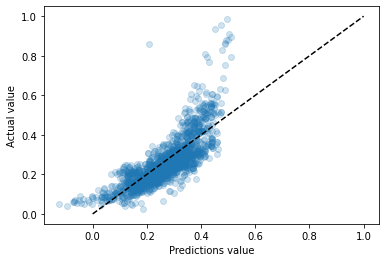

In [43]:
# Plot a perfect prediction line.
plt.plot([0, 1], [0, 1],  "--", color="black",)
# Plot the predictions vs the actual values.
plt.scatter(predictions, y_test, alpha=0.2)

plt.xlabel("Predictions value")
plt.ylabel("Actual value")
plt.show()

In [92]:
joblib.dump(lr_model, "trained_models/carprice_model_linear_regression.joblib")

['trained_models/carprice_model_linear_regression.joblib']

## **Train a simple Neural Network**

In [44]:
from sklearn.preprocessing import OneHotEncoder
from torch.utils.data import Dataset, DataLoader

In [46]:
ohe = OneHotEncoder(handle_unknown='ignore', sparse=False)

cat_train_array = ohe.fit_transform(df_train[CATEGORICAL_COLUMNS])
cat_test_array = ohe.transform(df_test[CATEGORICAL_COLUMNS])

In [47]:
joblib.dump(ohe, 'trained_models/cat_feature_one_hot_encoder.joblib') # save the one hot encoder

['trained_models/cat_feature_one_hot_encoder.joblib']

### Modify the preprocessing function to handle one-hot encoding

In [162]:
def preprocess_dataframe(
    dataframe: pd.DataFrame,
    cat_feature_dict: dict,
    max_value_dict: dict,
    one_hot_encoder = None,
    ) -> pd.DataFrame:

    for col in CATEGORICAL_COLUMNS:
        dataframe[col] = dataframe[col].apply(lambda x: cat_feature_dict[col][str(x)])
    for col in NUMERIC_COLUMNS:
        dataframe[col] = dataframe[col].apply(lambda x: scale_value(x, max_value_dict[col]))

    if one_hot_encoder:
        cat_feature_array = one_hot_encoder.transform(dataframe[CATEGORICAL_COLUMNS])
    else:
        cat_feature_array = dataframe[CATEGORICAL_COLUMNS].values

    numeric_feature_array = dataframe[NUMERIC_COLUMNS].values

    preprocessed_feature_array = np.hstack((cat_feature_array, numeric_feature_array))
    return preprocessed_feature_array

In [200]:
class CarPriceDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        if y is not None:
            self.y = y
        else:
            self.y = None

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        if self.y is not None:
            return self.X[idx], self.y[idx]
        else:
            return self.X[idx]

In [164]:
data_path = "Rodkaidee Data.csv"
cat_feature_dict_path = "trained_models/cat_feature_dict.json"
max_value_dict_path = "trained_models/max_value_dict.json"
one_hot_encoder_path = "trained_models/cat_feature_one_hot_encoder.joblib"

with open(cat_feature_dict_path, "r", encoding="utf-8") as f:
    cat_feature_dict = json.load(f)

with open(max_value_dict_path, "r", encoding="utf-8") as f:
    max_value_dict = json.load(f)

one_hot_encoder = joblib.load(one_hot_encoder_path)

In [165]:
df = pd.read_csv(data_path)
df_train, df_test = train_test_split(df, test_size=0.2, random_state=42)
x_train = preprocess_dataframe(
    df_train,
    cat_feature_dict = cat_feature_dict,
    max_value_dict = max_value_dict,
    one_hot_encoder = one_hot_encoder,
    )
y_train = df_train["Price"].apply(lambda x: scale_value(x, max_value_dict["Price"])).values
y_train = y_train.reshape(-1, 1)

x_test = preprocess_dataframe(
    df_test,
    cat_feature_dict = cat_feature_dict,
    max_value_dict = max_value_dict,
    one_hot_encoder = one_hot_encoder,
)
y_test = df_test["Price"].apply(lambda x: scale_value(x, max_value_dict["Price"])).values
y_test = y_test.reshape(-1, 1)
print(x_train.shape, y_train.shape)

(5918, 137) (5918, 1)


In [166]:
train_dataset = CarPriceDataset(x_train, y_train)
test_dataset = CarPriceDataset(x_test, y_test)

train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# x_sample, y_sample = next(iter(train_dataloader))
# x_sample, y_sample

In [167]:
class CarPriceModel(nn.Module):
    def __init__(self, input_size, output_size):
        super().__init__()
        self.linear = nn.Linear(input_size, output_size)

    def forward(self, x):
        out = self.linear(x)
        return out

In [168]:
model = CarPriceModel(input_size=x_train.shape[1], output_size=y_train.shape[1])
model

CarPriceModel(
  (linear): Linear(in_features=137, out_features=1, bias=True)
)

In [169]:
def train(
    model,
    train_dataloader,
    test_dataloader,
    optimizer,
    loss_fn = nn.MSELoss(reduction='mean'),
    num_epochs = 100,
    update_frequency = 10,
    ):
    for epoch in tqdm(range(num_epochs)):
        # Set the model to training mode.
        model.train()
        for x, y in train_dataloader:
            # Forward pass.
            y_pred = model(x.float())
            # Calculate the loss.
            loss = loss_fn(y_pred, y.float())
            # Backward pass.
            loss.backward()
            # Update the model parameters.
            optimizer.step()
            # Reset the gradients.
            optimizer.zero_grad()
        # Save the training loss.
        train_losses.append(loss.item())

        # Set the model to evaluation mode and calculate the test loss at the end of each epoch.
        model.eval()
        with torch.no_grad():
            for x, y in test_dataloader:
                # Forward pass.
                y_pred = model(x.float())
                # Calculate the loss.
                loss = loss_fn(y_pred, y.float())

            # Print the loss if the epoch is a multiple of 10.
            if epoch % update_frequency == 0:
                print(f"Epoch {epoch}: {loss.item()}")

def predict(model, test_dataloader):
    model.eval()
    prediction_list = []
    actual_y_list = []
    for x, y in test_dataloader:
        y_pred = model(x.float())
        prediction = y_pred.detach().numpy()
        y = y.numpy()
        prediction_list.append(prediction)
        actual_y_list.append(y)
    return prediction_list, actual_y_list

In [109]:
# Define the loss function and the optimizer.
learning_rate = 1e-3 # = 0.001
loss_fn = nn.MSELoss(reduction="mean")
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Train the model.
num_epochs = 120
update_frequency = 10

train(
    model = model,
    train_dataloader = train_dataloader,
    test_dataloader = test_dataloader,
    optimizer = optimizer,
    loss_fn = loss_fn,
    num_epochs = num_epochs,
    update_frequency = update_frequency,
    )

  0%|          | 0/120 [00:00<?, ?it/s]

Epoch 0: 0.012425843626260757
Epoch 10: 0.00978908408433199
Epoch 20: 0.012031314894557
Epoch 30: 0.010402164421975613
Epoch 40: 0.009714426472783089
Epoch 50: 0.009771863929927349
Epoch 60: 0.009241846390068531
Epoch 70: 0.00992899015545845
Epoch 80: 0.010496396571397781
Epoch 90: 0.009687892161309719
Epoch 100: 0.010201600380241871
Epoch 110: 0.010514281690120697


### Evaluate the model on the test set with Mean Squared Error

In [110]:
# Get the predictions for the test set.
prediction_list, actual_y_list = predict(model, test_dataloader)

In [111]:
actual_y_array = np.concatenate(actual_y_list)
prediction_array = np.concatenate(prediction_list)
mean_squared_error(prediction_array, actual_y_array)

0.006706728130270595

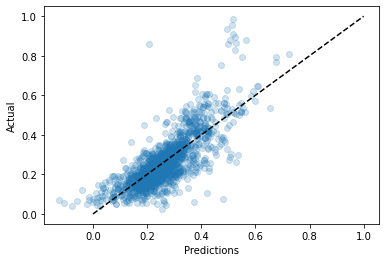

In [86]:
# Plot a perfect prediction line.
plt.plot([0, 1], [0, 1],  "--", color="black",)
# Plot the predictions vs the actual values.
plt.scatter(prediction_array, actual_y_array, alpha=0.2)

plt.xlabel("Predictions")
plt.ylabel("Actual")
plt.show()

In [87]:
torch.save(model.state_dict(), "trained_models/carprice_model_mse_000668.pth")

## **Train a Neural Network with multiple layers (MLP)**

In [171]:
class CarPriceDoubleModel(nn.Module):
    def __init__(self, input_size, output_size, intermediate_dim = 10):
        super().__init__()
        self.linear1 = nn.Linear(input_size, intermediate_dim)
        self.linear2 = nn.Linear(intermediate_dim, output_size)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.linear1(x)
        x = self.relu(x)
        x = self.linear2(x)
        return x

double_model = CarPriceDoubleModel(input_size=x_train.shape[1], output_size=y_train.shape[1])

In [172]:
# Define the loss function and the optimizer.
learning_rate = 1e-3 # = 0.001
loss_fn = nn.MSELoss(reduction="mean")
optimizer = torch.optim.Adam(double_model.parameters(), lr=learning_rate)

# Train the model.
num_epochs = 120
update_frequency = 10

train(
    model = double_model,
    train_dataloader = train_dataloader,
    test_dataloader = test_dataloader,
    optimizer = optimizer,
    loss_fn = loss_fn,
    num_epochs = num_epochs,
    update_frequency = update_frequency,
    )

  0%|          | 0/120 [00:00<?, ?it/s]

Epoch 0: 0.009131699800491333
Epoch 10: 0.012577999383211136
Epoch 20: 0.013686644844710827
Epoch 30: 0.012472383677959442
Epoch 40: 0.012354840524494648
Epoch 50: 0.008995736949145794
Epoch 60: 0.015759840607643127
Epoch 70: 0.014012464322149754
Epoch 80: 0.010830432176589966
Epoch 90: 0.01449971366673708
Epoch 100: 0.012379922904074192
Epoch 110: 0.013779125176370144


In [173]:
prediction_list, actual_y_list = predict(mlp_model, test_dataloader)
prediction_array = np.concatenate(prediction_list)
actual_y_array = np.concatenate(actual_y_list)
mse_score = mean_squared_error(prediction_array, actual_y_array)
mse_score

0.0054332452508565774

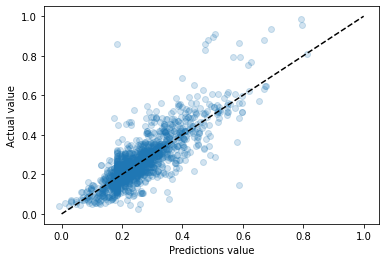

In [174]:
# Plot a perfect prediction line.
plt.plot([0, 1], [0, 1],  "--", color="black",)
# Plot the predictions vs the actual values.
plt.scatter(prediction_array, actual_y_array, alpha=0.2)

plt.xlabel("Predictions value")
plt.ylabel("Actual value")
plt.show()

In [175]:
mse_identifier = round(mse_score, 5)
mse_identifier = str(mse_identifier).replace(".", "")

torch.save(mlp_model.state_dict(), f"trained_models/carprice_double_model_mse_{mse_identifier}.pth")

## **Use the models to predict on new data**

In [183]:

CATEGORICAL_COLUMNS = ["Brand", "Model", "Engine", "Segment", "Province", "Color"]
NUMERIC_COLUMNS = ["Year", "Mileage"]

class CarPriceModel(nn.Module):
    def __init__(self, input_size, output_size):
        super().__init__()
        self.linear = nn.Linear(input_size, output_size)

    def forward(self, x):
        out = self.linear(x)
        return out

def preprocess_dataframe(
    dataframe: pd.DataFrame,
    cat_feature_dict: dict,
    max_value_dict: dict,
    one_hot_encoder = None,
    ) -> pd.DataFrame:
    """
    Preprocesses a dataframe by replacing categorical values with their corresponding id values.
    Scales numeric values to be between 0 and 1 using the given max_value_dict.
    Applies one-hot encoding to the categorical columns if one_hot_encoder is provided.
    Returns a numpy array of the preprocessed features.
    """
    # Replace categorical values with their corresponding id values.
    for col in CATEGORICAL_COLUMNS:
        dataframe[col] = dataframe[col].apply(lambda x: cat_feature_dict[col][str(x)])
    # Scale numeric values to be between 0 and 1.
    for col in NUMERIC_COLUMNS:
        dataframe[col] = dataframe[col].apply(lambda x: scale_value(x, max_value_dict[col]))

    # Apply one-hot encoding to the categorical columns.
    if one_hot_encoder:
        cat_feature_array = one_hot_encoder.transform(dataframe[CATEGORICAL_COLUMNS])
    else:
        cat_feature_array = dataframe[CATEGORICAL_COLUMNS].values

    numeric_feature_array = dataframe[NUMERIC_COLUMNS].values
    # Concatenate the one-hot encoded categorical columns with the numeric columns.
    preprocessed_feature_array = np.hstack((cat_feature_array, numeric_feature_array))
    return preprocessed_feature_array

@torch.no_grad()
def pytorch_predict_car_price(
    dataframe: pd.DataFrame,
    model: CarPriceModel,
    cat_feature_dict: dict,
    max_value_dict: dict,
    one_hot_encoder = None,
    ) -> float:
    """
    Predicts car price from a dataframe with the given pytorch model.
    """
    model.eval()
    preprocessed_feature_array = preprocess_dataframe(
        dataframe,
        cat_feature_dict=cat_feature_dict,
        max_value_dict=max_value_dict,
        one_hot_encoder=one_hot_encoder,
        )
    preprocessed_feature_tensor = torch.from_numpy(preprocessed_feature_array)
    prediction_tensor = model(preprocessed_feature_tensor.float())
    prediction_array = prediction_tensor.detach().numpy()
    # Scale the prediction back to the original scale.
    prediction_array *= max_value_dict["Price"]
    return prediction_array


def sklearn_predict_car_price(
    dataframe: pd.DataFrame,
    sklearn_model: LinearRegression,
    cat_feature_dict: dict,
    max_value_dict: dict,
    ) -> float:
    """
    Predicts car price from a dataframe with the given sklearn model.
    """
    preprocessed_feature_array = preprocess_dataframe(
        dataframe,
        cat_feature_dict=cat_feature_dict,
        max_value_dict=max_value_dict,
        )
    prediction_array = sklearn_model.predict(preprocessed_feature_array)
    # Scale the prediction back to the original scale.
    prediction_array *= max_value_dict["Price"]
    return prediction_array

In [178]:
data_path = "Rodkaidee Data.csv"
cat_feature_dict_path = "trained_models/cat_feature_dict.json"
max_value_dict_path = "trained_models/max_value_dict.json"
one_hot_encoder_path = "trained_models/cat_feature_one_hot_encoder.joblib"

with open(cat_feature_dict_path, "r", encoding="utf-8") as f:
    cat_feature_dict = json.load(f)

with open(max_value_dict_path, "r", encoding="utf-8") as f:
    max_value_dict = json.load(f)

one_hot_encoder = joblib.load(one_hot_encoder_path)

Pytorch

In [181]:
model = CarPriceModel(137, 1)
model.load_state_dict(torch.load("trained_models/carprice_model_mse_000668.pth"))

df = pd.read_csv(data_path)
df_train, df_test = train_test_split(df, test_size=0.2, random_state=42)

predictions = pytorch_predict_car_price(
    dataframe=df_test,
    model=model,
    cat_feature_dict = cat_feature_dict,
    max_value_dict = max_value_dict,
    one_hot_encoder = one_hot_encoder,
)

Sklearn

In [106]:
lr_model = joblib.load("trained_models/carprice_model_linear_regression.joblib")

df = pd.read_csv(data_path)
df_train, df_test = train_test_split(df, test_size=0.2, random_state=42)

predictions = sklearn_predict_car_price(
    dataframe=df_test,
    sklearn_model=lr_model,
    cat_feature_dict = cat_feature_dict,
    max_value_dict = max_value_dict,
)

## Step-by-step guide to model usage

In [187]:
CATEGORICAL_COLUMNS = ["Brand", "Model", "Engine", "Segment", "Province", "Color"]
NUMERIC_COLUMNS = ["Year", "Mileage"]

data_path = "Rodkaidee Data.csv"
cat_feature_dict_path = "trained_models/cat_feature_dict.json"
max_value_dict_path = "trained_models/max_value_dict.json"
one_hot_encoder_path = "trained_models/cat_feature_one_hot_encoder.joblib"

with open(cat_feature_dict_path, "r", encoding="utf-8") as f:
    cat_feature_dict = json.load(f)

with open(max_value_dict_path, "r", encoding="utf-8") as f:
    max_value_dict = json.load(f)

one_hot_encoder = joblib.load(one_hot_encoder_path)

cat_feature_dict.keys()

dict_keys(['Brand', 'Model', 'Engine', 'Segment', 'Province', 'Color'])

In [188]:
max_value_dict

{'Price': 1420000.0, 'Mileage': 600000.0, 'Year': 2022.0}

In [194]:
df = pd.read_csv(data_path)
df_train, df_test = train_test_split(df, test_size=0.2, random_state=42)

In [195]:
# Replace categorical values with their corresponding id values.
for col in CATEGORICAL_COLUMNS:
    df_test[col] = df_test[col].apply(lambda x: cat_feature_dict[col][str(x)])
# Scale numeric values to be between 0 and 1.
for col in NUMERIC_COLUMNS:
    df_test[col] = df_test[col].apply(lambda x: scale_value(x, max_value_dict[col]))

In [196]:
# Apply one-hot encoding to the categorical columns.
if one_hot_encoder:
    cat_feature_array = one_hot_encoder.transform(df_test[CATEGORICAL_COLUMNS])
else:
    cat_feature_array = df_test[CATEGORICAL_COLUMNS].values

numeric_feature_array = df_test[NUMERIC_COLUMNS].values
# Concatenate the one-hot encoded categorical columns with the numeric columns.
preprocessed_feature_array = np.hstack((cat_feature_array, numeric_feature_array))

In [201]:
carprice_dataset = CarPriceDataset(X=preprocessed_feature_array, y=None)
carprice_dataloader = DataLoader(carprice_dataset, batch_size=32, shuffle=False)

In [202]:
prediction_list = []
for x in carprice_dataloader:
    y_pred = model(x.float())
    prediction = y_pred.detach().numpy().ravel()
    prediction_list.extend(prediction)

In [203]:
df_test["Predicted_price"] = np.array(prediction_list) * max_value_dict["Price"]

In [204]:
df_test

,Brand,Model,Engine,Segment,Year,Mileage,Province,Price,Color,Predicted_price
2473,2,11,6,3,0.997033,0.123518,0,"619,000",2,604392.062500
6730,0,3,4,1,0.992087,0.433333,0,"139,000",1,153437.875000
2847,1,4,0,0,0.996538,0.159122,1,"389,000",0,378340.375000
169,0,6,1,2,0.999011,0.033333,0,"488,000",1,454693.343750
2036,4,15,1,2,0.997033,0.183333,3,"259,000",4,257817.453125
...,...,...,...,...,...,...,...,...,...,...
210,0,0,0,0,0.999011,0.023333,0,"539,000",0,478372.093750
2484,2,11,6,3,0.997033,0.166667,0,"629,000",0,598234.812500
6305,0,3,4,1,0.993076,0.189127,0,"218,000",3,332081.093750
110,4,15,1,2,0.999011,0.021667,16,"385,000",0,391964.843750


Try plotting actual vs predicted values for the test set in the original scale (not normalized)

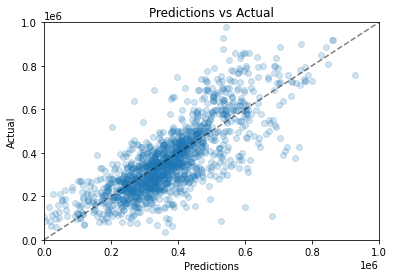

In [215]:
plt.plot([0, 1_000_000], [0, 1_000_000], color="black", alpha=0.5, linestyle="--")

actual_price_array = df_test["Price"].apply(lambda x: x.replace(",", "")).values.astype(float)
plt.scatter(df_test["Predicted_price"].values, actual_price_array, alpha=0.2)

plt.xlabel("Predictions")
plt.ylabel("Actual")
plt.title("Predictions vs Actual")

plt.xlim(0, 1_000_000)
plt.ylim(0, 1_000_000)
plt.show()